# CRF RNN - Train

## Load libraries

In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os


In [2]:
import os
import numpy as np
import random
import matplotlib.pyplot as plt
from cv2 import imread, resize, cvtColor, COLOR_BGR2RGB

from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from tensorflow_addons.layers import CRF

c:\Users\lucas\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Set parameters

In [3]:
input_dir_train = "train"
input_dir_train_images = os.path.join(input_dir_train, 'JPEGImages')
input_dir_train_annotations = os.path.join(input_dir_train, 'Annotations')

img_size = (320, 320)
batch_size = 16

## Create DataGenerator

In [4]:
class DataGen(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_dir_images, input_dir_annotations, mode):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_dir_images = input_dir_images
        self.input_dir_annotations = input_dir_annotations
        
        self.mode = mode
        self.input_images = self._get_images(input_dir_images)
        self.input_images = self.input_images[:1000] if mode == 'train' else self.input_images[100:]
        self.input_annotations = self._get_images(input_dir_annotations)
        self.input_annotations = self.input_annotations[:1000] if mode == 'train' else self.input_annotations[100:]

    def __len__(self):
        return len(self.input_images) // self.batch_size
    
    def _get_images(self, input_dir_images):
        images = []
        for dir in os.listdir(input_dir_images):
            full_path = os.path.join(input_dir_images, dir)
            images += [os.path.join(dir, image) for image in os.listdir(full_path)]
        return images
    
    def _get_image(self, image_path, annotation=False):
        image = imread(image_path)
        image = resize(image, self.img_size)
        image = cvtColor(image, COLOR_BGR2RGB)
        image = image/255
        if annotation:
            image[image!=0] = 1
        return image

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_images[i : i + self.batch_size]
        X = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        Y = X.copy()
        for k, path in enumerate(batch_input_img_paths):
            image_path = os.path.join(self.input_dir_images, path)
            X[k] = self._get_image(image_path)
            
            annotation_path = os.path.join(self.input_dir_annotations, path)
            Y[k] = self._get_image(annotation_path[:-4]+'.png', True)
        return X, Y

## Instantiate data Sequences for each split

In [5]:
train_gen = DataGen(batch_size, img_size, input_dir_train_images, input_dir_train_annotations, 'train')
val_gen = DataGen(batch_size, img_size, input_dir_train_images, input_dir_train_annotations, 'val')
print(len(train_gen), len(val_gen))

62 5905


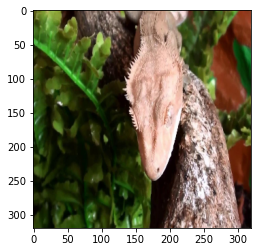

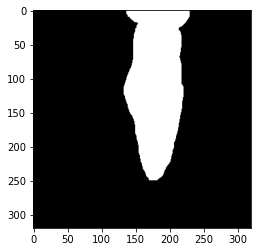

In [6]:
X, Y = val_gen.__getitem__(500)
plt.imshow(X[1])
plt.show()
plt.imshow(Y[1])

## Create and instantiate model

In [7]:
def get_CRF_RNN(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual
        
    a,b,c,d = x.shape
    x = layers.Reshape((b*c, d))(x)
    decoded_sequence, potentials, sequence_length, chain_kernel = CRF(num_classes+1)(x)
    x = layers.Reshape((1, b, c, -1))(potentials)

    # Add a per-pixel classification layer
    outputs = layers.ConvLSTM2D(3, 3, activation="softmax", padding='same')(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_CRF_RNN(img_size, 1)
model.compile(optimizer=keras.optimizers.experimental.RMSprop(), loss="binary_crossentropy")
model.summary()


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                           

## Fit model

In [8]:
print(len(train_gen), len(val_gen))

62 5905


In [9]:
model.fit(
    train_gen, 
    epochs=3, 
    validation_data=val_gen, 
    callbacks=keras.callbacks.ModelCheckpoint("youtube.h5", save_best_only=True))


Epoch 1/3
62/62 [==============================] - ETA: 0s - loss: 0.6438

## Display val dataset exemples

In [ ]:
model.load_weights("youtube.h5")

1/1 [==============================] - 0s 494ms/step


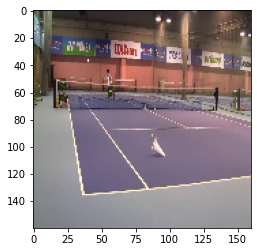

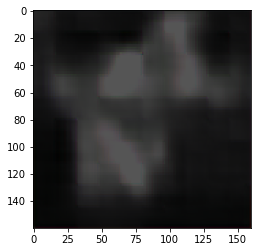

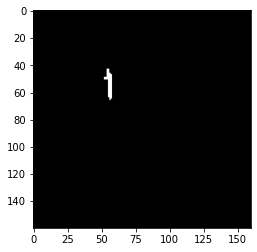

In [ ]:
image_index = random.randint(0, len(val_gen))
preds = model.predict(val_gen[image_index][0])

plt.hist(preds[10].flat)
plt.imshow(val_gen[image_index][0][10])
plt.show()
plt.imshow(preds[10])
plt.show()
plt.imshow(val_gen[image_index][1][10])